In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.signal import welch
from scipy.optimize import curve_fit

from scipy.fft import rfft, irfft, rfftfreq

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/../analysis_utils.py'>

In [40]:
def read_recon(dataset):
    file = rf'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/pulse_calibration/{dataset}_processed.hdf5'
    voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

    amps_all, pulse_shapes_all = [], []
    f = h5py.File(file, 'r')
    for v in voltages:
        amps = f['data_processed'][f'amplitudes_{v}v'][:]
        ps = f['data_processed'][f'pulse_shapes_{v}v'][:]

        amps_all.append(amps)
        pulse_shapes_all.append(ps)
    amps_noise = f['data_processed'][f'amplitudes_noise_2.5v'][:]
    amps_noise_search = f['data_processed'][f'amplitudes_noise_search_2.5v'][:]
    f.close()

    return amps_all, pulse_shapes_all, amps_noise, amps_noise_search


In [52]:
dataset_0 = '20251215_p8e_5e-8mbar_d137khz_0'
dataset_1 = '20251215_p8e_5e-8mbar_d137khz_1'
dataset_2 = '20251217_p8e_5e-8mbar_d137khz_0'
dataset_3 = '20251217_p8e_5e-8mbar_d137khz_1'
datasets = [dataset_0, dataset_1, dataset_2, dataset_3]

amps_all_0, pulse_shapes_all_0, amps_noise_0, amps_noise_search_0 = read_recon(dataset_0)
amps_all_1, pulse_shapes_all_1, amps_noise_1, amps_noise_search_1 = read_recon(dataset_1)
amps_all_2, pulse_shapes_all_2, amps_noise_2, amps_noise_search_2 = read_recon(dataset_2)
amps_all_3, pulse_shapes_all_3, amps_noise_3, amps_noise_search_3 = read_recon(dataset_3)

amp2keV 7863.650700812016
Fitted sigma: [ 79.71763298  83.54071384 122.74961227 126.91891534 134.94916749
 121.58916604 128.72419649 129.14386301] keV/c
Noise level 0.013532562411844673 arb. amplitude
Noise level 106.4153438936847 keV/c
amp2keV 8103.694942383209
Fitted sigma: [ 81.85778994  99.51067373 118.30948388 105.52395977 129.7936684
 121.29764951 143.40519967 153.58099452] keV/c
Noise level 0.01529716446705558 arb. amplitude
Noise level 123.96355432448244 keV/c
amp2keV 8261.765887351632
Fitted sigma: [ 60.92186564  79.27953367  92.04182694 121.38450771 120.64509131
 115.41326644  95.48985938  88.43764519] keV/c
Noise level 0.01177676044146514 arb. amplitude
Noise level 97.29683767880884 keV/c
amp2keV 8341.50365053655
Fitted sigma: [ 61.40121583  88.69088437 109.79001902 106.16047643 113.38266885
 112.75907614  92.24196075 100.69748446] keV/c
Noise level 0.012428168681871085 arb. amplitude
Noise level 103.66961442931168 keV/c
amp2keV 8171.343370691745
Fitted sigma: [ 77.44591581 

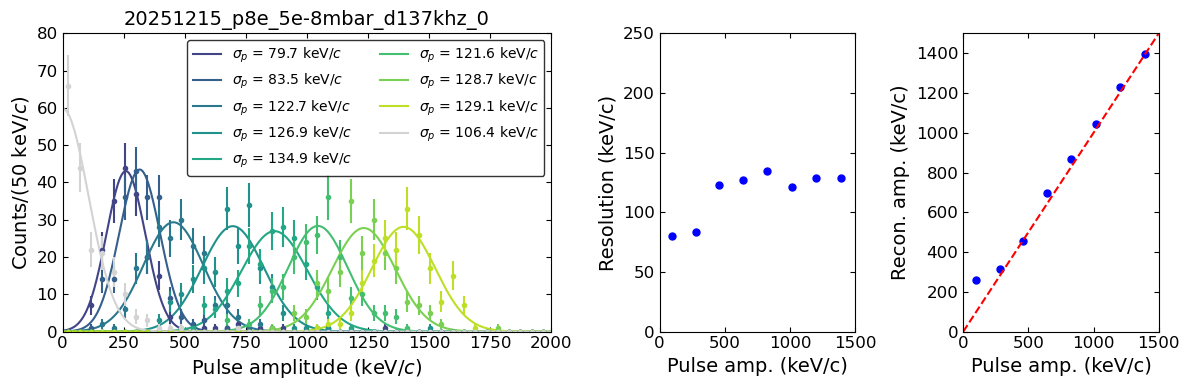

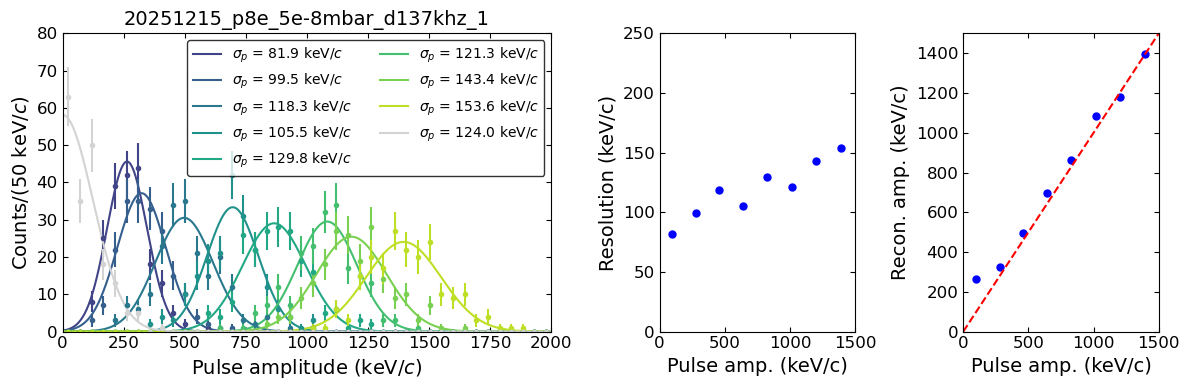

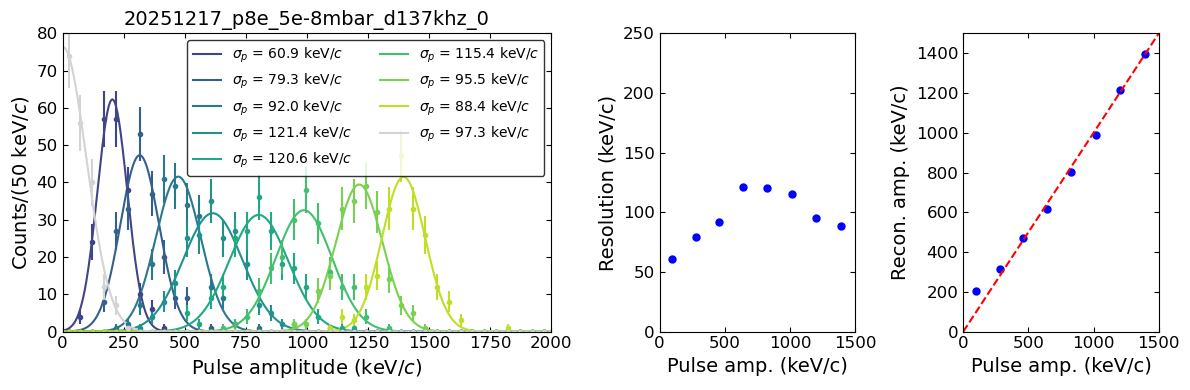

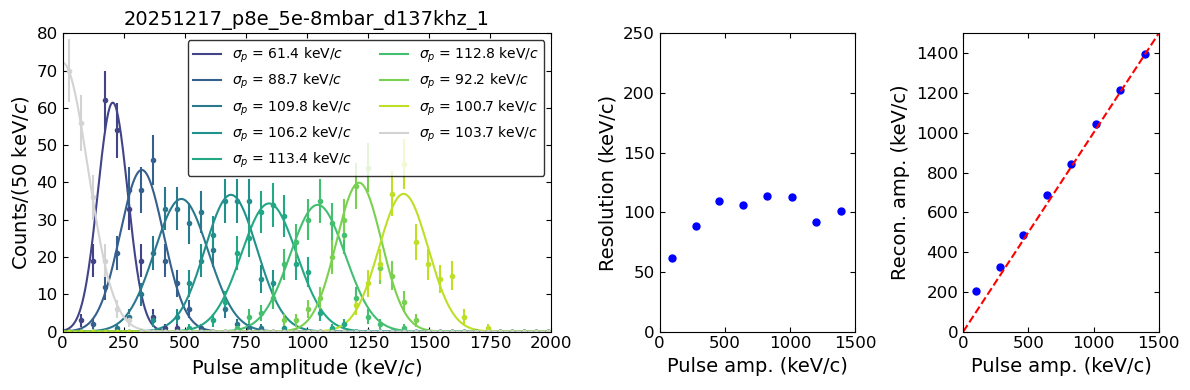

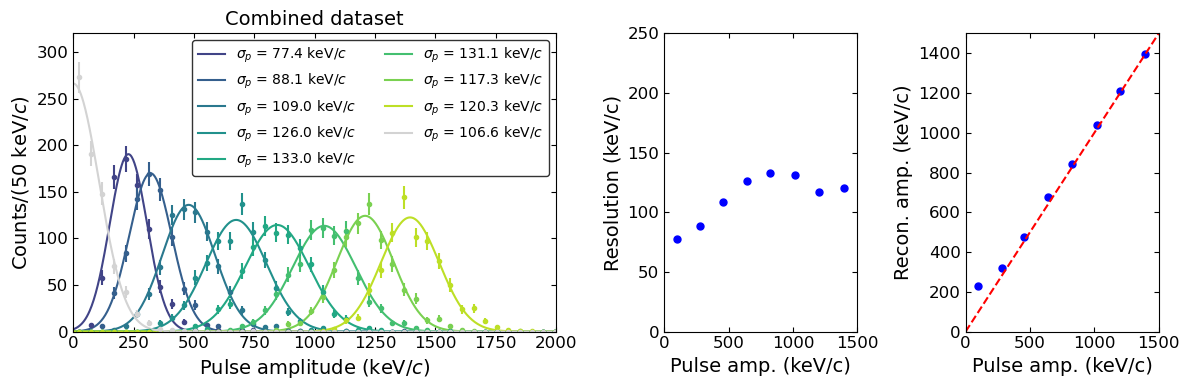

In [54]:
pulse_amp = np.asarray([99, 279, 456, 643, 824, 1018, 1202, 1395])
amps_all = [amps_all_0, amps_all_1, amps_all_2, amps_all_3, [np.concatenate([amps_all_0[i], amps_all_1[i], amps_all_2[i], amps_all_3[i]]) for i in range(8)]]
amps_noise_all = [amps_noise_0, amps_noise_1, amps_noise_2, amps_noise_3, np.concatenate([amps_noise_0, amps_noise_1, amps_noise_2, amps_noise_3])]

for j in range(5):
    bins = np.arange(0, 3000, 50) / 8500
    hhs, bcs, gps = utils.fit_amps_gaus(amps_all[j], bins=bins, noise=False, return_bins=False)
    hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise_all[j]], bins=bins, noise=True, return_bins=False)

    amp2kevs = pulse_amp / np.asarray(gps).T[1]
    amp2kev = amp2kevs[-1]

    print('amp2keV', amp2kev)
    print('Fitted sigma:', np.asarray(gps).T[2]*amp2kev, 'keV/c')

    xx = np.linspace(0, np.max(bcs[0]), 1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), width_ratios=[2.5, 1, 1])

    cmap = plt.colormaps.get_cmap('viridis')
    colors = cmap(np.linspace(0.2, 0.9, 8))
    for i in range(pulse_amp.size):
        axes[0].errorbar(bcs[i]*amp2kev, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
        axes[0].plot(xx*amp2kev, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev:.1f} keV/$c$', color=colors[i])

    axes[0].errorbar(bcs_noise[0]*amp2kev, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
    axes[0].plot(xx*amp2kev, utils.gauss_zero(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][1]*amp2kev:.1f} keV/$c$', color='lightgrey')

    print('Noise level', gps_noise[0][1], 'arb. amplitude')
    print('Noise level', gps_noise[0][1]*amp2kev, 'keV/c')

    axes[0].set_xlim(0, 2000)
    axes[0].legend(edgecolor='k', ncol=2, fontsize=10)
    axes[0].set_xlabel(r'Pulse amplitude (keV/$c$)')
    axes[0].set_ylabel(r'Counts/(50 keV/$c$)')

    if j == 4:
        axes[0].set_title(f'Combined dataset')
        axes[0].set_ylim(0, 320)
    else:
        axes[0].set_title(f'{datasets[j]}')
        axes[0].set_ylim(0, 80)

    axes[1].plot(pulse_amp, np.asarray(gps).T[2]*amp2kev, 'b.', markersize=10)
    axes[1].set_xlim(0, 1500)
    axes[1].set_ylim(0, 250)
    axes[1].set_xlabel('Pulse amp. (keV/c)')
    axes[1].set_ylabel('Resolution (keV/c)')
    # axes[1].plot(np.linspace(0, 1500, 50), np.full(50, gps_noise[0][1]*amp2kev_all), 'k--')

    axes[2].plot(pulse_amp, np.asarray(gps).T[1]*amp2kev, 'b.', markersize=10)
    axes[2].plot(np.linspace(0, 1500, 50), np.linspace(0, 1500, 50), 'r--')
    axes[2].set_xlim(0, 1500)
    axes[2].set_ylim(0, 1500)
    axes[2].set_xlabel('Pulse amp. (keV/c)')
    axes[2].set_ylabel('Recon. amp. (keV/c)')

    fig.tight_layout()

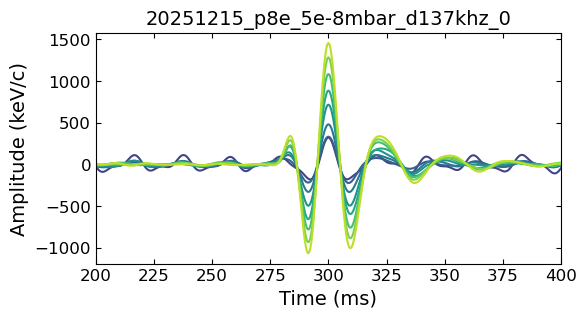

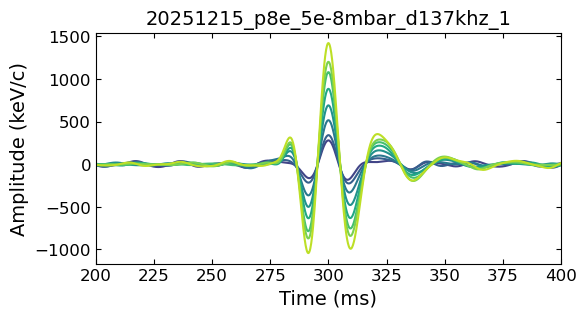

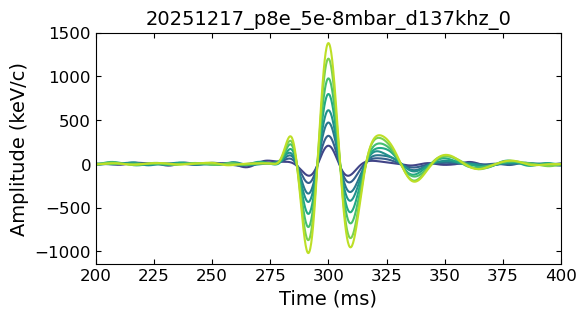

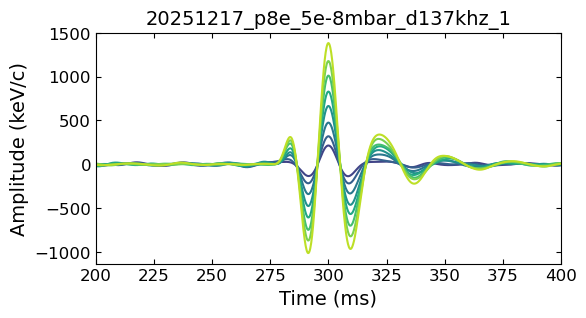

In [27]:
amp2kev_all = 8676.983393504359

tt = np.arange(3000) * 200e-9
pulse_shapes_all = [pulse_shapes_all_0, pulse_shapes_all_1, pulse_shapes_all_2, pulse_shapes_all_3]

for j in range(4):
    plt.figure(figsize=(6, 3))
    for i in range(8):
        # for _ps in pulse_shapes_all[j][i]:
        #     plt.plot(tt/1e-6, _ps*amp2kev_all, 'lightgray', alpha=0.3)
        plt.plot(tt/1e-6, np.mean(pulse_shapes_all[j][i], axis=0)*amp2kev_all, color=colors[i])
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (keV/c)')
    plt.title(datasets[j])
    plt.xlim(200, 400)
    # plt.ylim(0, 1500)
    plt.plot()

In [24]:
pulse_shape_template_all = []
for i in range(8):
    pulse_shape_template = np.zeros(pulse_shapes_all_0[0].shape[1], dtype=np.float64)

    count = 0
    for j in range(4):
        pulse_shape_template += np.sum(pulse_shapes_all[j][i], axis=0)
        count += pulse_shapes_all[j][i].shape[0]
    pulse_shape_template /= count
    # print(count)
    
    pulse_shape_template_all.append(pulse_shape_template * amp2kev_all)

np.savez(r'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/pulse_calibration/sphere_20251212_pulse_shape_template_combined.npz', 
         ps_2_5v=pulse_shape_template_all[0],
         ps_5v=pulse_shape_template_all[1],
         ps_7_5v=pulse_shape_template_all[2],
         ps_10v=pulse_shape_template_all[3],
         ps_12_5v=pulse_shape_template_all[4],
         ps_15v=pulse_shape_template_all[5],
         ps_17_5v=pulse_shape_template_all[6],
         ps_20v=pulse_shape_template_all[7])

[]

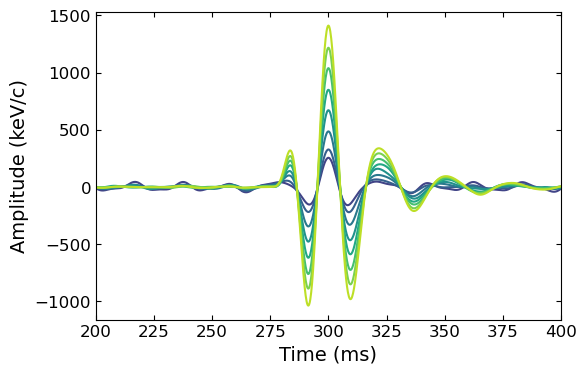

In [30]:
pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/pulse_calibration/sphere_20251212_pulse_shape_template_combined.npz')
pulse_shape_template_all = [pulse_shape_file['ps_2_5v'],
                            pulse_shape_file['ps_5v'],
                            pulse_shape_file['ps_7_5v'],
                            pulse_shape_file['ps_10v'],
                            pulse_shape_file['ps_12_5v'],
                            pulse_shape_file['ps_15v'],
                            pulse_shape_file['ps_17_5v'],
                            pulse_shape_file['ps_20v']]
pulse_shape_file.close()

plt.figure(figsize=(6, 4))
for i in range(8):

    plt.plot(tt/1e-6, pulse_shape_template_all[i], color=colors[i])

    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (keV/c)')
plt.xlim(200, 400)
plt.plot()